In [1]:
from pyxtal import Group, Wyckoff_position
from pymatgen.core import Structure, Composition
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius

import rich
import pandas as pda
import seaborn as sns
import rho_plus as rp
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

%load_ext rich

In [2]:
from baysic.utils import load_mp20
from baysic.wyckoff_span import Plane, Line, Point

df = load_mp20('train')

In [4]:
row = df.iloc[300]
row


Unnamed: 0                                                               19463
material_id                                                          mp-867201
formation_energy_per_atom                                            -0.388914
band_gap                                                                   0.0
pretty_formula                                                         CaInHg2
e_above_hull                                                               0.0
struct                       [[0. 0. 0.] Ca, [5.00000041e-11 6.42913531e+00...
comp                                                              (Ca, In, Hg)
sg_number                                                                  225
sg_symbol                                                                Fm-3m
conv                         [[0. 0. 0.] Ca, [0.       3.711863 3.711863] C...
hall                                                                  -F 4 2 3
wyckoffs                                           

In [33]:
row['struct'].species

[Element Ca, Element In, Element Hg, Element Hg]

In [34]:
from baysic.wyckoff_span import is_nonzero
import numpy as np
spans = []
span_radii = []

sga = SpacegroupAnalyzer(row['struct'])
equiv_atoms = sga.get_symmetry_dataset()['equivalent_atoms']

symm = row['struct']
sg_num = row['sg_number']
species = symm.species
i = 0
processed = set()
for specie, symbol, equiv in zip(species, row['wyckoffs'], equiv_atoms):
    if equiv in processed:
        continue
    else:
        processed.add(equiv)

    wp = Wyckoff_position.from_group_and_letter(sg_num, symbol, style='spglib')
    if wp.get_dof() != 3:
        radius = CovalentRadius.radius[specie.symbol]
        for op in wp.ops:
            n_dof = sum(is_nonzero(op.rotation_matrix, axis=0))
            span = (Point, Line, Plane)[n_dof](op)
            did_add = False
            for span_i, prev_span in enumerate(spans):
                if span.dim == prev_span.dim and span == prev_span:
                    print(span, prev_span)
                    span_radii[span_i].append(radius)
                    did_add = True
                    break
            if not did_add:
                spans.append(span)
                span_radii.append([radius])

for span, radii in zip(spans, span_radii):
    min_dist_ratios = np.linspace(0.6, 1, 30)
    assert span.fits(symm.lattice, np.array(radii) * min_dist_ratios[0])
    prev_min = min_dist_ratios[0]
    for curr_min in min_dist_ratios[1:]:
        if not span.fits(row['lattice'], np.array(radii) * curr_min):
            break
        else:
            prev_min = curr_min

prev_min

1.0

In [26]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

sga = SpacegroupAnalyzer(row['struct'])

sga.get_symmetry_dataset()


{
    'number': 225,
    'hall_number': 523,
    'international': 'Fm-3m',
    'hall': '-F 4 2 3',
    'choice': '',
    'transformation_matrix': array([[5.00000000e-01, 5.00000000e-01, 0.00000000e+00],
       [5.55111512e-17, 5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.55111512e-17, 5.00000000e-01]]),
    'origin_shift': array([0., 0., 0.]),
    'rotations': array([[[ 1,  0,  0],
        [ 0,  1,  0],
        [ 0,  0,  1]],

       [[-1,  0,  0],
        [ 0, -1,  0],
        [ 0,  0, -1]],

       [[ 0, -1,  0],
        [ 0,  0, -1],
        [ 1,  1,  1]],

       [[ 0,  1,  0],
        [ 0,  0,  1],
        [-1, -1, -1]],

       [[ 0,  0,  1],
        [-1, -1, -1],
        [ 1,  0,  0]],

       [[ 0,  0, -1],
        [ 1,  1,  1],
        [-1,  0,  0]],

       [[ 1,  1,  1],
        [-1,  0,  0],
        [ 0, -1,  0]],

       [[-1, -1, -1],
        [ 1,  0,  0],
        [ 0,  1,  0]],

       [[ 0,  1,  0],
        [ 1,  0,  0],
        [-1, -1, -1]],

       [[ 

In [31]:
sga.get_refined_structure()

If you see this text, the Crystal Toolkit Jupyter Lab 

extension is not installed. You can install it by running 

"pip install crystaltoolkit-extension" 

from the same environment you run "jupyter lab". 

This only works in Jupyter Lab 3.x or above.


Structure Summary
Lattice
    abc : 7.423726005260346 7.423726005260346 7.423726005260346
 angles : 90.0 90.0 90.0
 volume : 409.1342183979201
      A : 7.423726005260346 0.0 0.0
      B : 0.0 7.423726005260346 0.0
      C : 0.0 0.0 7.423726005260346
    pbc : True True True
PeriodicSite: Ca (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Ca (0.0, 3.712, 3.712) [0.0, 0.5, 0.5]
PeriodicSite: Ca (3.712, 0.0, 3.712) [0.5, 0.0, 0.5]
PeriodicSite: Ca (3.712, 3.712, 0.0) [0.5, 0.5, 0.0]
PeriodicSite: In (3.712, 0.0, 0.0) [0.5, 0.0, 0.0]
PeriodicSite: In (3.712, 3.712, 3.712) [0.5, 0.5, 0.5]
PeriodicSite: In (0.0, 0.0, 3.712) [0.0, 0.0, 0.5]
PeriodicSite: In (0.0, 3.712, 0.0) [0.0, 0.5, 0.0]
PeriodicSite: Hg (1.856, 5.568, 5.568) [0.25, 0.75, 0

In [14]:
span_radii


[
    [1.76],
    [1.76],
    [1.76],
    [1.76],
    [1.76],
    [1.76],
    [1.76],
    [1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76],
    [1.76, 1.76]
]

In [21]:
import numpy as np
import pyvista as pv
from pymatgen.core import SymmOp
pv.set_plot_theme('dark' if IS_DARK else 'default')
pv.set_jupyter_backend('trame')
pl: pv.plotting.plotter.Plotter = pv.Plotter()

cube = pv.Cube(center=(0.5, 0.5, 0.5))
pl.add_mesh(cube, color=cs[0], style='wireframe')

# op = SymmOp.from_xyz_str('x, 2x, -z+1/2')
op = SymmOp.from_xyz_str('-x, x, z')
tau = op.operate(np.ones(3) * 1e-2) % 1
normal = np.cross(*op.rotation_matrix[:, ~np.all(abs(op.rotation_matrix) <= 1e-6, axis=0)].T)
pl.add_mesh(pv.Plane(tau, normal, 1, 3), color=cs[1], opacity=0.6)
pl.add_title(op.as_xyz_str())
pl.show()

Widget(value="<iframe src='http://localhost:44477/index.html?ui=P_0x7fda8009a290_9&reconnect=auto' style='widt…

In [8]:
from baysic.wyckoff_span import WyckoffSpan,

array([-1.,  1.,  0.])

In [26]:
op.rotation_matrix[:, ~np.all(abs(op.rotation_matrix) <= 1e-6, axis=0)]


array([[ 1.,  0.],
       [ 2.,  0.],
       [ 0., -1.]])

In [13]:
import pickle

with open('all_wps.pkl', 'rb') as all_wps_file:
    all_wps = pickle.load(all_wps_file)

len(all_wps)

939

In [20]:
for wp in all_wps:
    for op in wp.ops:
        is_0 = np.abs(op.rotation_matrix) <= 1e-6
        if np.sum(is_0.all(axis=1)) == 3 - 2 and np.sum(is_0.all(axis=0)) == 3 - 3:
            print(op.as_xyz_str())

<Axes: xlabel='int_val', ylabel='count'>

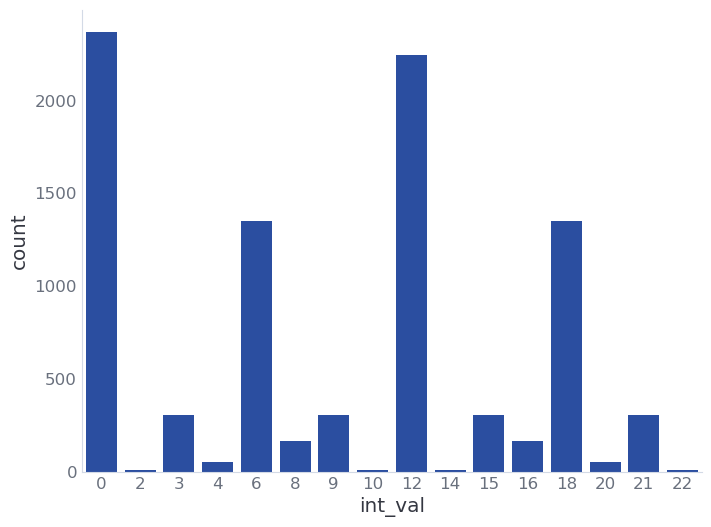

In [3]:
import numpy as np
wp_pos_df = []
for i, wp in enumerate(all_wps):
    for op in wp.ops:
        for row, tau, ax in zip(op.rotation_matrix, op.translation_vector, 'xyz'):
            if np.linalg.norm(row) <= 1e-6:
                wp_pos_df.append([i, tau % 1, ax])

wp_pos_df = pd.DataFrame(wp_pos_df, columns=['wp', 'val', 'ax'])
wp_pos_df['int_val'] = (wp_pos_df['val'] * 24).round().astype(int)
assert np.allclose(wp_pos_df['int_val'] / 24, wp_pos_df['val'])
sns.countplot(wp_pos_df, x='int_val')

In [4]:
wp_pos_df.query('int_val == 21')

,wp,val,ax,int_val
2126,339,0.875,x,21
2127,339,0.875,y,21
2129,339,0.875,y,21
2134,339,0.875,x,21
2143,339,0.875,y,21
...,...,...,...,...
8960,938,0.875,z,21
8962,938,0.875,y,21
8969,938,0.875,z,21
8971,938,0.875,y,21


Plane testing: try 107

In [5]:
for wp in Group(96).Wyckoff_positions:
    print(wp.multiplicity, wp.letter, '\t', ' | '.join(['{:>20}'.format(op.as_xyz_string()) for op in wp.ops]))
print(wp.symbol)

8 b 	              x, y, z |        -x, -y, z+1/2 | -y+1/2, x+1/2, z+3/4 | y+1/2, -x+1/2, z+1/4 | -x+1/2, y+1/2, -z+3/4 | x+1/2, -y+1/2, -z+1/4 |             y, x, -z |       -y, -x, -z+1/2
4 a 	              x, x, 0 |          -x, -x, 1/2 |   -x+1/2, x+1/2, 3/4 |   x+1/2, -x+1/2, 1/4
P43212


/tmp/ipykernel_413565/3614056665.py:2: DeprecationWarning: `as_xyz_string` is deprecated!
Use as_xyz_str instead
  print(wp.multiplicity, wp.letter, '\t', ' | '.join(['{:>20}'.format(op.as_xyz_string()) for op in wp.ops]))


In [6]:
import numpy as np
from pymatgen.core import SymmOp
def is_nonzero(arr, **kwargs):
    return np.linalg.norm(arr, **kwargs) >= 1e-6

# op = spot.ops[0]
op: SymmOp = Wyckoff_position.from_group_and_letter(140, '16i').ops[3]
rot = op.rotation_matrix
tau = op.translation_vector


class Line:
    """A 1D Wyckoff span."""
    def __init__(self, op: SymmOp):
        rot = op.rotation_matrix
        tau = op.translation_vector

        free_vars = np.where(is_nonzero(rot, axis=0))[0]
        if len(free_vars) != 1:
            raise ValueError(f'{op} is not a line, len({free_vars}) != 1')
        p = rot[:, free_vars[0]].flatten()

        p /= np.linalg.norm(p)
        # p * t + τ is line
        # want to find intersection with unit cube

        # we're working mod 1: a WP like x, -x, 0.25
        # doesn't ever intersect the unit cube except at 0
        # instead, we need to "wiggle" τ to get out of edges
        # and then find how to move it into the unit cube
        # first, wiggle the point to get out of corners
        # this is equivalent to x+ε, -(x+ε), 0.25
        self.tau = (p * 1e-3 + tau) % 1
        self.t_min = -np.inf
        self.t_max = np.inf
        for ax in range(3):
            if abs(p[ax]) <= 1e-6:
                # no movement on this axis
                # can safely ignore: doesn't help us bound
                continue
            else:
                # solve for t such that p[ax] * t + τ[ax] = 0 and 1
                bound = [(b - self.tau[ax]) / p[ax] for b in (0, 1)]
                min_b, max_b = sorted(bound)
                # print(ax, min_b, max_b)
                self.t_min = max(min_b, self.t_min)
                self.t_max = min(max_b, self.t_max)

        # the center is independent of which intercept we started
        # with and antiparallel lines: two lines are equivalent
        # iff centers match and angle between dirs is 0 or 180
        self.bottom = p * self.t_min + self.tau
        self.top = p * self.t_max + self.tau
        self.middle = 0.5 * (self.bottom + self.top)
        self.p = p

    def __eq__(self, other):
        # this will break with __hash__: we're going to ignore that
        return np.allclose(self.middle, other.middle) and np.isclose(abs(np.dot(self.p, other.p)), 1)

    def __repr__(self):
        px, py, pz = self.p.round(3).flatten()
        tx, ty, tz = self.tau.round(3).flatten()
        return f'{px}x + {tx}, {py}y + {ty}, {pz}z + {tz}'

    def __call__(self, t):
        return self.p * t + self.tau

    @property
    def vec(self) -> np.array:
        """A vector representing the segment in fractional space."""
        return self.p * (self.t_max - self.t_min)

l1 = Segment(op)
l2 = Segment(SymmOp.from_rotation_and_translation(-2.1 * op.rotation_matrix, op.translation_vector + np.arange(3) + 1))

l1 == l2

True

In [8]:
def parse_ops(sg: Group):
    lines = []
    line_wps = []
    for wp in sg.Wyckoff_positions:
        for i, op in enumerate(wp.ops):
            n_dofs = sum(is_nonzero(op.rotation_matrix, axis=0))
            if n_dofs == 1:  # forms a line
                l = Segment(op)
                did_add = False
                for l_i, other in enumerate(lines):
                    if other == l:
                        # already have this line
                        line_wps[l_i].add((wp.letter, i))
                        did_add = True
                        break

                if not did_add:
                    # new line
                    lines.append(l)
                    line_wps.append({(wp.letter, i)})

    return (lines, line_wps)

sg = Group(10)
print(sg)
print(parse_ops(sg)[1])

-- Spacegroup --# 10 (P2/m)--
4o	site symm: 1
2n	site symm: .m.
2m	site symm: .m.
2l	site symm: .2.
2k	site symm: .2.
2j	site symm: .2.
2i	site symm: .2.
1h	site symm: .2/m.
1g	site symm: .2/m.
1f	site symm: .2/m.
1e	site symm: .2/m.
1d	site symm: .2/m.
1c	site symm: .2/m.
1b	site symm: .2/m.
1a	site symm: .2/m.
[{('l', 0), ('l', 1)}, {('k', 0), ('k', 1)}, {('j', 0), ('j', 1)}, {('i', 0), ('i', 1)}]


In [9]:
all_lines = []
all_line_wps = []
groups = []
for sg_n in range(2, 231):
    sg = Group(sg_n)
    lines, line_wps = parse_ops(sg)
    groups.append(sg)
    all_lines.append(lines)
    all_line_wps.append(line_wps)



In [10]:
list(zip([group.symbol for group in groups], all_line_wps))


[
    ('P-1', []),
    ('P2', [{('d', 0)}, {('c', 0)}, {('b', 0)}, {('a', 0)}]),
    ('P21', []),
    ('C2', [{('b', 0)}, {('b', 1)}, {('a', 0)}, {('a', 1)}]),
    ('Pm', []),
    ('Pc', []),
    ('Cm', []),
    ('Cc', []),
    (
        'P2/m',
        [{('l', 0), ('l', 1)}, {('k', 0), ('k', 1)}, {('j', 0), ('j', 1)}, {('i', 0), ('i', 1)}]
    ),
    ('P21/m', []),
    (
        'C2/m',
        [{('h', 1), ('h', 0)}, {('h', 2), ('h', 3)}, {('g', 0), ('g', 1)}, {('g', 2), ('g', 3)}]
    ),
    ('P2/c', [{('f', 0)}, {('f', 1)}, {('e', 0)}, {('e', 1)}]),
    ('P21/c', []),
    ('C2/c', [{('e', 0)}, {('e', 1)}, {('e', 2)}, {('e', 3)}]),
    (
        'P222',
        [
            {('t', 0), ('t', 1)},
            {('s', 0), ('s', 1)},
            {('r', 0), ('r', 1)},
            {('q', 0), ('q', 1)},
            {('p', 1), ('p', 0)},
            {('o', 1), ('o', 0)},
            {('n', 1), ('n', 0)},
            {('m', 1), ('m', 0)},
            {('l', 0), ('l', 1)},
            {('k', 

In [11]:
for group, lwps in zip(groups, all_line_wps):
    for s in lwps:
        lets = {x[0] for x in s}
        if len(lets) > 1:
            print(group, lwps)

In [12]:
l1.top

array([1.00000000e+00, 1.11022302e-16, 2.50000000e-01])

In [27]:
import numpy as np
from pymatgen.core import Lattice

comp = Composition('Ag4C2O6')

sg = Group(115)

all_assignments = sg.list_wyckoff_combinations(list(comp.get_el_amt_dict().values()))[0]
print(len(all_assignments))
all_assignments[0]

6660


[['1d', '1c', '1b', '1a'], ['2e'], ['2e', '2e', '2e']]

In [28]:
lat = Lattice.monoclinic(3.17, 9.66, 4.92, 93.95).matrix

assignment = all_assignments[1]
radii = []
for el, spots in zip(comp.elements, assignment):
    radii.extend([CovalentRadius.radius[el.symbol] for _ in range(len(spots))])

radii = np.array(radii)
spots = [Wyckoff_position.from_group_and_letter(sg.number, spot) for spot in sum(assignment, [])]

print(radii)
for spot in spots:
    print(spot)

[1.45 1.45 1.45 1.45 0.73 0.66 0.66 0.66]
Wyckoff position 1d in space group 115 with site symmetry -4 m 2
0, 0, 1/2
Wyckoff position 1c in space group 115 with site symmetry -4 m 22
1/2, 1/2, 1/2
Wyckoff position 1b in space group 115 with site symmetry -4 m 22
1/2, 1/2, 0
Wyckoff position 1a in space group 115 with site symmetry -4 m 2
0, 0, 0
Wyckoff position 2e in space group 115 with site symmetry 2 mm .
0, 0, z
0, 0, -z
Wyckoff position 2f in space group 115 with site symmetry 2 m .
1/2, 1/2, z
1/2, 1/2, -z
Wyckoff position 2e in space group 115 with site symmetry 2 mm .
0, 0, z
0, 0, -z
Wyckoff position 2e in space group 115 with site symmetry 2 mm .
0, 0, z
0, 0, -z


In [38]:
from string import ascii_lowercase
lines, line_wps = parse_ops(sg)
wps = sg.Wyckoff_positions
wp_counts = np.zeros((len(wps), len(lines)), dtype=int)

for i, lwps in enumerate(line_wps):
    for let, _num in lwps:
        wp_counts[ascii_lowercase.index(let), i] += 1

wp_counts


array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 2, 2, 0, 0, 0, 0],
       [2, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
capacities = np.zeros(len(wps))
capacities

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
wps


[
    Wyckoff position 8l in space group 115 with site symmetry 1
x, y, z
-x, -y, z
y, -x, -z
-y, x, -z
x, -y, z
-x, y, z
y, x, -z
-y, -x, -z,
    Wyckoff position 4k in space group 115 with site symmetry . m .
x, 1/2, z
-x, 1/2, z
1/2, -x, -z
1/2, x, -z,
    Wyckoff position 4j in space group 115 with site symmetry . m .
x, 0, z
-x, 0, z
0, -x, -z
0, x, -z,
    Wyckoff position 4i in space group 115 with site symmetry . . 2
x, x, 1/2
-x, -x, 1/2
x, -x, 1/2
-x, x, 1/2,
    Wyckoff position 4h in space group 115 with site symmetry . . 2
x, x, 0
-x, -x, 0
x, -x, 0
-x, x, 0,
    Wyckoff position 2g in space group 115 with site symmetry 2 mm .
0, 1/2, z
1/2, 0, -z,
    Wyckoff position 2f in space group 115 with site symmetry 2 m .
1/2, 1/2, z
1/2, 1/2, -z,
    Wyckoff position 2e in space group 115 with site symmetry 2 mm .
0, 0, z
0, 0, -z,
    Wyckoff position 1d in space group 115 with site symmetry -4 m 2
0, 0, 1/2,
    Wyckoff position 1c in space group 115 with site symmetry -4 m 2